## Filter Methods - Basics - Correlations - Univariate ROC-AUC
### Putting it all together

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [2]:
# load the Santander customer satisfaction dataset from Kaggle

data = pd.read_csv('santander-train.csv')
data.shape

(76020, 371)

In [3]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((53214, 370), (22806, 370))

In [4]:
# Keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

### Remove constant features

In [5]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((53214, 332), (22806, 332))

### Remove quasi-constant features

In [6]:
# remove quasi-constant features
# 0.1 indicates 99% of observations approximately
sel = VarianceThreshold(threshold=0.01)  
# fit finds the features with low variance
sel.fit(X_train)  
# how many not quasi-constant?
sum(sel.get_support()) 

268

In [7]:
features_to_keep = X_train.columns[sel.get_support()]

In [8]:
# we can then remove the features like this
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((53214, 268), (22806, 268))

In [9]:
# sklearn transformations lead to numpy arrays
# here we transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

### Remove duplicated features

In [10]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


16

In [11]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((53214, 252), (22806, 252))

In [12]:
# Keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

### Remove correlated features

In [13]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  133


In [14]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((53214, 119), (22806, 119))

In [15]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

### Remove features using univariate roc_auc

In [16]:
# find important features using univariate roc-auc

# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set

roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

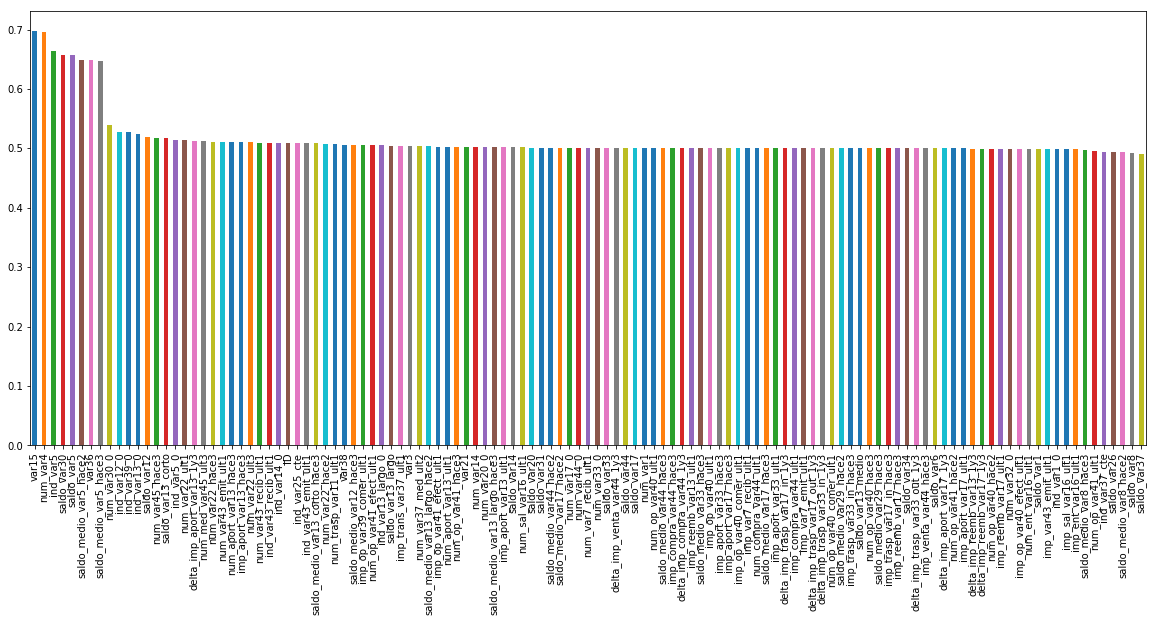

In [17]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [18]:
# by removing features with univariate roc_auc == 0.5
# we remove another 30 features

selected_feat = roc_values[roc_values>0.5]
len(selected_feat), X_train.shape[1]

(90, 119)

### Compare the performance in machine learning algorithms

In [19]:
# create a function to build random forests and compare performance in train and test set

def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [20]:
# original
run_randomForests(X_train_original.drop(labels=['ID'], axis=1),
                  X_test_original.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8012314741948454
Test set
Random Forests roc-auc: 0.7900499757912425


In [21]:
# filter methods - basic
run_randomForests(X_train_basic_filter.drop(labels=['ID'], axis=1),
                  X_test_basic_filter.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8016577097093865
Test set
Random Forests roc-auc: 0.791033019265853


In [22]:
# filter methods - correlation
run_randomForests(X_train_corr.drop(labels=['ID'], axis=1),
                  X_test_corr.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8073914001626228
Test set
Random Forests roc-auc: 0.7937667747098247


In [23]:
# filter methods - univariate roc-auc
run_randomForests(X_train[selected_feat.index],
                  X_test_corr[selected_feat.index],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8105671870819526
Test set
Random Forests roc-auc: 0.7985492537265694


We can see that removing constant, quasi-constant, duplicated, correlated and now **features with univariate roc-auc ==0.5** we still keep or even enhance the performance of the random forests (0.7985 vs 0.7900) at the time that we reduce the feature space dramatically (from 371 to 90).

Let's have a look at the performance of logistic regression.

In [24]:
# create a function to build logistic regression and compare performance in train and test set

def run_logistic(X_train, X_test, y_train, y_test):
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(random_state=44)
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [25]:
# original
scaler = StandardScaler().fit(X_train_original.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_original.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_original.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train set
Logistic Regression roc-auc: 0.8070000657665616
Test set
Logistic Regression roc-auc: 0.7936246657052465


In [26]:
# filter methods - basic
scaler = StandardScaler().fit(X_train_basic_filter.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_basic_filter.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_basic_filter.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train set
Logistic Regression roc-auc: 0.8063201105177173
Test set
Logistic Regression roc-auc: 0.7932285496615372


In [27]:
# filter methods - correlation
scaler = StandardScaler().fit(X_train_corr.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_corr.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_corr.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train set
Logistic Regression roc-auc: 0.7964877479885147
Test set
Logistic Regression roc-auc: 0.7929021762293591


In [28]:
# filter methods - univariate roc-auc
scaler = StandardScaler().fit(X_train[selected_feat.index])

run_logistic(scaler.transform(X_train[selected_feat.index]),
             scaler.transform(X_test_corr[selected_feat.index]),
                  y_train, y_test)

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train set
Logistic Regression roc-auc: 0.7928877480632495
Test set
Logistic Regression roc-auc: 0.7946621588934099


Similarly, removing constant, quasi-constant, duplicated, correlated and those with univariate roc_auc == 0.5, helped improve the performance of logistic regression (0.795 vs 0.794) at the time it reduced the feature space dramatically (371 to 90).

We have now an equally or even slightly more predictive model that is at the time simpler, as it uses less than a third of the original features.